# EDA

This notebook constitutes our exploratory data analysis. It is also the notebook used for generating the plots that are included in our report.

### Setup

In [1]:
%%capture
cd ..

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import patsy

import statsmodels.api as sm
import statsmodels.formula.api as smf

import cleaner as cln
import constants as const
import utils

In [3]:
try:
    from IPython.display import set_matplotlib_formats
except Exception:
    from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('png', 'pdf')

<ipython-input-3-a45f45949d5c>:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
def save_fig(filename):
    new_filename = "./" + filename
    plt.savefig(new_filename, bbox_inches = 'tight')

### Read data and visualise missing values per row

In [6]:
df_raw = pd.read_csv(const.TRAIN_PATH)

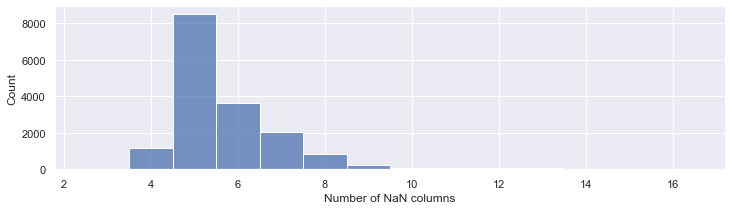

In [7]:
matplotlib.rcParams['figure.figsize'] = (12, 3)
sns.set()

number_nans = df_raw.apply(lambda row: sum(map(utils.isnan, row)), axis=1)
sns.histplot(number_nans, discrete=True)
plt.xlabel('Number of NaN columns')
save_fig('num-nans.pdf')
plt.show()

### Rudimentary cleaning

In [8]:
# Handling date function with a manual call
df = cln.handle_date_fields(df_raw, is_test=True)

# Handling make from title checkout
df = cln.handle_make(df)

# Handling fuel_type from data + scraper
df = cln.handle_fuel_type(df)

# Dropping definite columns that aren't going to come in use
df.drop(columns=["opc_scheme", "indicative_price", "eco_category"], inplace=True)

df.isnull().sum()

listing_id            0
title                 0
make                  0
model                 0
description         345
manufactured          0
type_of_vehicle       0
category              0
transmission          0
curb_weight         579
power              2337
fuel_type             0
engine_cap           53
no_of_owners        176
depreciation        433
coe                 891
road_tax           2154
dereg_value        1189
mileage            3724
omv                  41
arf                 284
features            459
accessories        2813
price                 0
registered_date       0
car_age               0
dtype: int64

In [9]:
df_cl = df.copy()
df_cl = cln.handle_make_model(df_cl)

In [10]:
to_drop = [
    "listing_id",
    "title",
    "make",
    "model",
    "description",
    "manufactured",
    "accessories",
    "features",
    "registered_date"
]


df_cl.drop(columns=to_drop, inplace=True)
df_cl.isnull().sum()

type_of_vehicle       0
category              0
transmission          0
curb_weight         579
power              2337
fuel_type             0
engine_cap           53
no_of_owners        176
depreciation        433
coe                 891
road_tax           2154
dereg_value        1189
mileage            3724
omv                  41
arf                 284
price                 0
car_age               0
make_model            0
dtype: int64

### Correlation-related plots

In [11]:
df_cl.corr()

,curb_weight,power,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,price,car_age,make_model
curb_weight,1.000000,0.669867,0.799242,-0.007923,0.110635,0.049650,0.640940,0.103412,0.002556,0.274464,0.115930,0.138473,0.022927,0.138303
power,0.669867,1.000000,0.884905,0.144118,0.591131,0.251833,0.842316,0.699425,-0.139015,0.849986,0.843883,0.769550,-0.003482,0.775805
engine_cap,0.799242,0.884905,1.000000,0.126226,0.347337,0.048805,0.966132,0.303947,-0.004413,0.619083,0.478709,0.418161,0.059730,0.452576
no_of_owners,-0.007923,0.144118,0.126226,1.000000,0.020780,-0.163647,0.284439,-0.206982,0.532323,0.127511,0.104119,-0.092642,0.389461,0.028912
depreciation,0.110635,0.591131,0.347337,0.020780,1.000000,0.281593,0.489024,0.555946,-0.158536,0.678950,0.656705,0.631857,-0.023237,0.642424
coe,0.049650,0.251833,0.048805,-0.163647,0.281593,1.000000,0.110904,0.331103,-0.005319,0.160858,0.234678,0.047125,-0.093206,0.138883
road_tax,0.640940,0.842316,0.966132,0.284439,0.489024,0.110904,1.000000,0.459083,0.018472,0.816899,0.769150,0.610232,0.092518,0.696376
dereg_value,0.103412,0.699425,0.303947,-0.206982,0.555946,0.331103,0.459083,1.000000,-0.376528,0.712710,0.849308,0.894838,-0.197490,0.769315
mileage,0.002556,-0.139015,-0.004413,0.532323,-0.158536,-0.005319,0.018472,-0.376528,1.000000,-0.149942,-0.170006,-0.387148,0.354204,-0.242273
omv,0.274464,0.849986,0.619083,0.127511,0.678950,0.160858,0.816899,0.712710,-0.149942,1.000000,0.938438,0.804580,-0.003968,0.854755


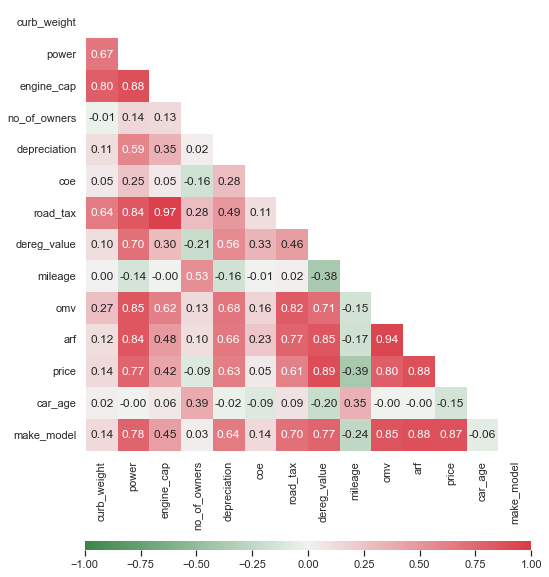

In [12]:
def plot_correlation_heatmap(df, save=False):
    # Hardcode these parameters for this type of plot
    matplotlib.rcParams['figure.figsize'] = (8, 10)
    sns.set(style="white")

    # Generate a mask for the upper triangle
    correlation = df.corr()
    mask = np.zeros_like(correlation, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure to control size of heatmap
    grid_kws = {"height_ratios": (5, .1), "hspace": 0.4}
    f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)

    # Create a custom color palette
    # as_cmap returns a matplotlib colormap object rather than a list of colors
    # Green = Good (low correlation), Red = Bad (high correlation) between the independent variables
    cmap = sns.diverging_palette(h_neg=133, h_pos=10, as_cmap=True)

    # Plot the heatmap
    ax = sns.heatmap(correlation, mask=mask, annot=True,
                     fmt='.2f', square=True,
                     cmap=cmap, vmin=-1, vmax=1,
                     ax=ax, cbar_ax=cbar_ax,
                     cbar_kws={"orientation": "horizontal"})

    if save:
        save_fig('correlation.pdf')

    plt.show()


plot_correlation_heatmap(df_cl, save=True)

In [13]:
df_cl_1 = df_cl.drop(columns=["coe", "no_of_owners"])
df_cl_1 = df_cl_1.dropna()
# power,  - needs to be extrapolated

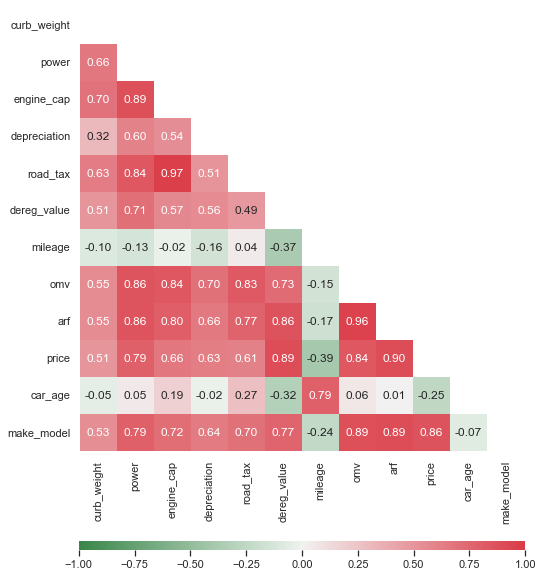

In [14]:
plot_correlation_heatmap(df_cl_1)

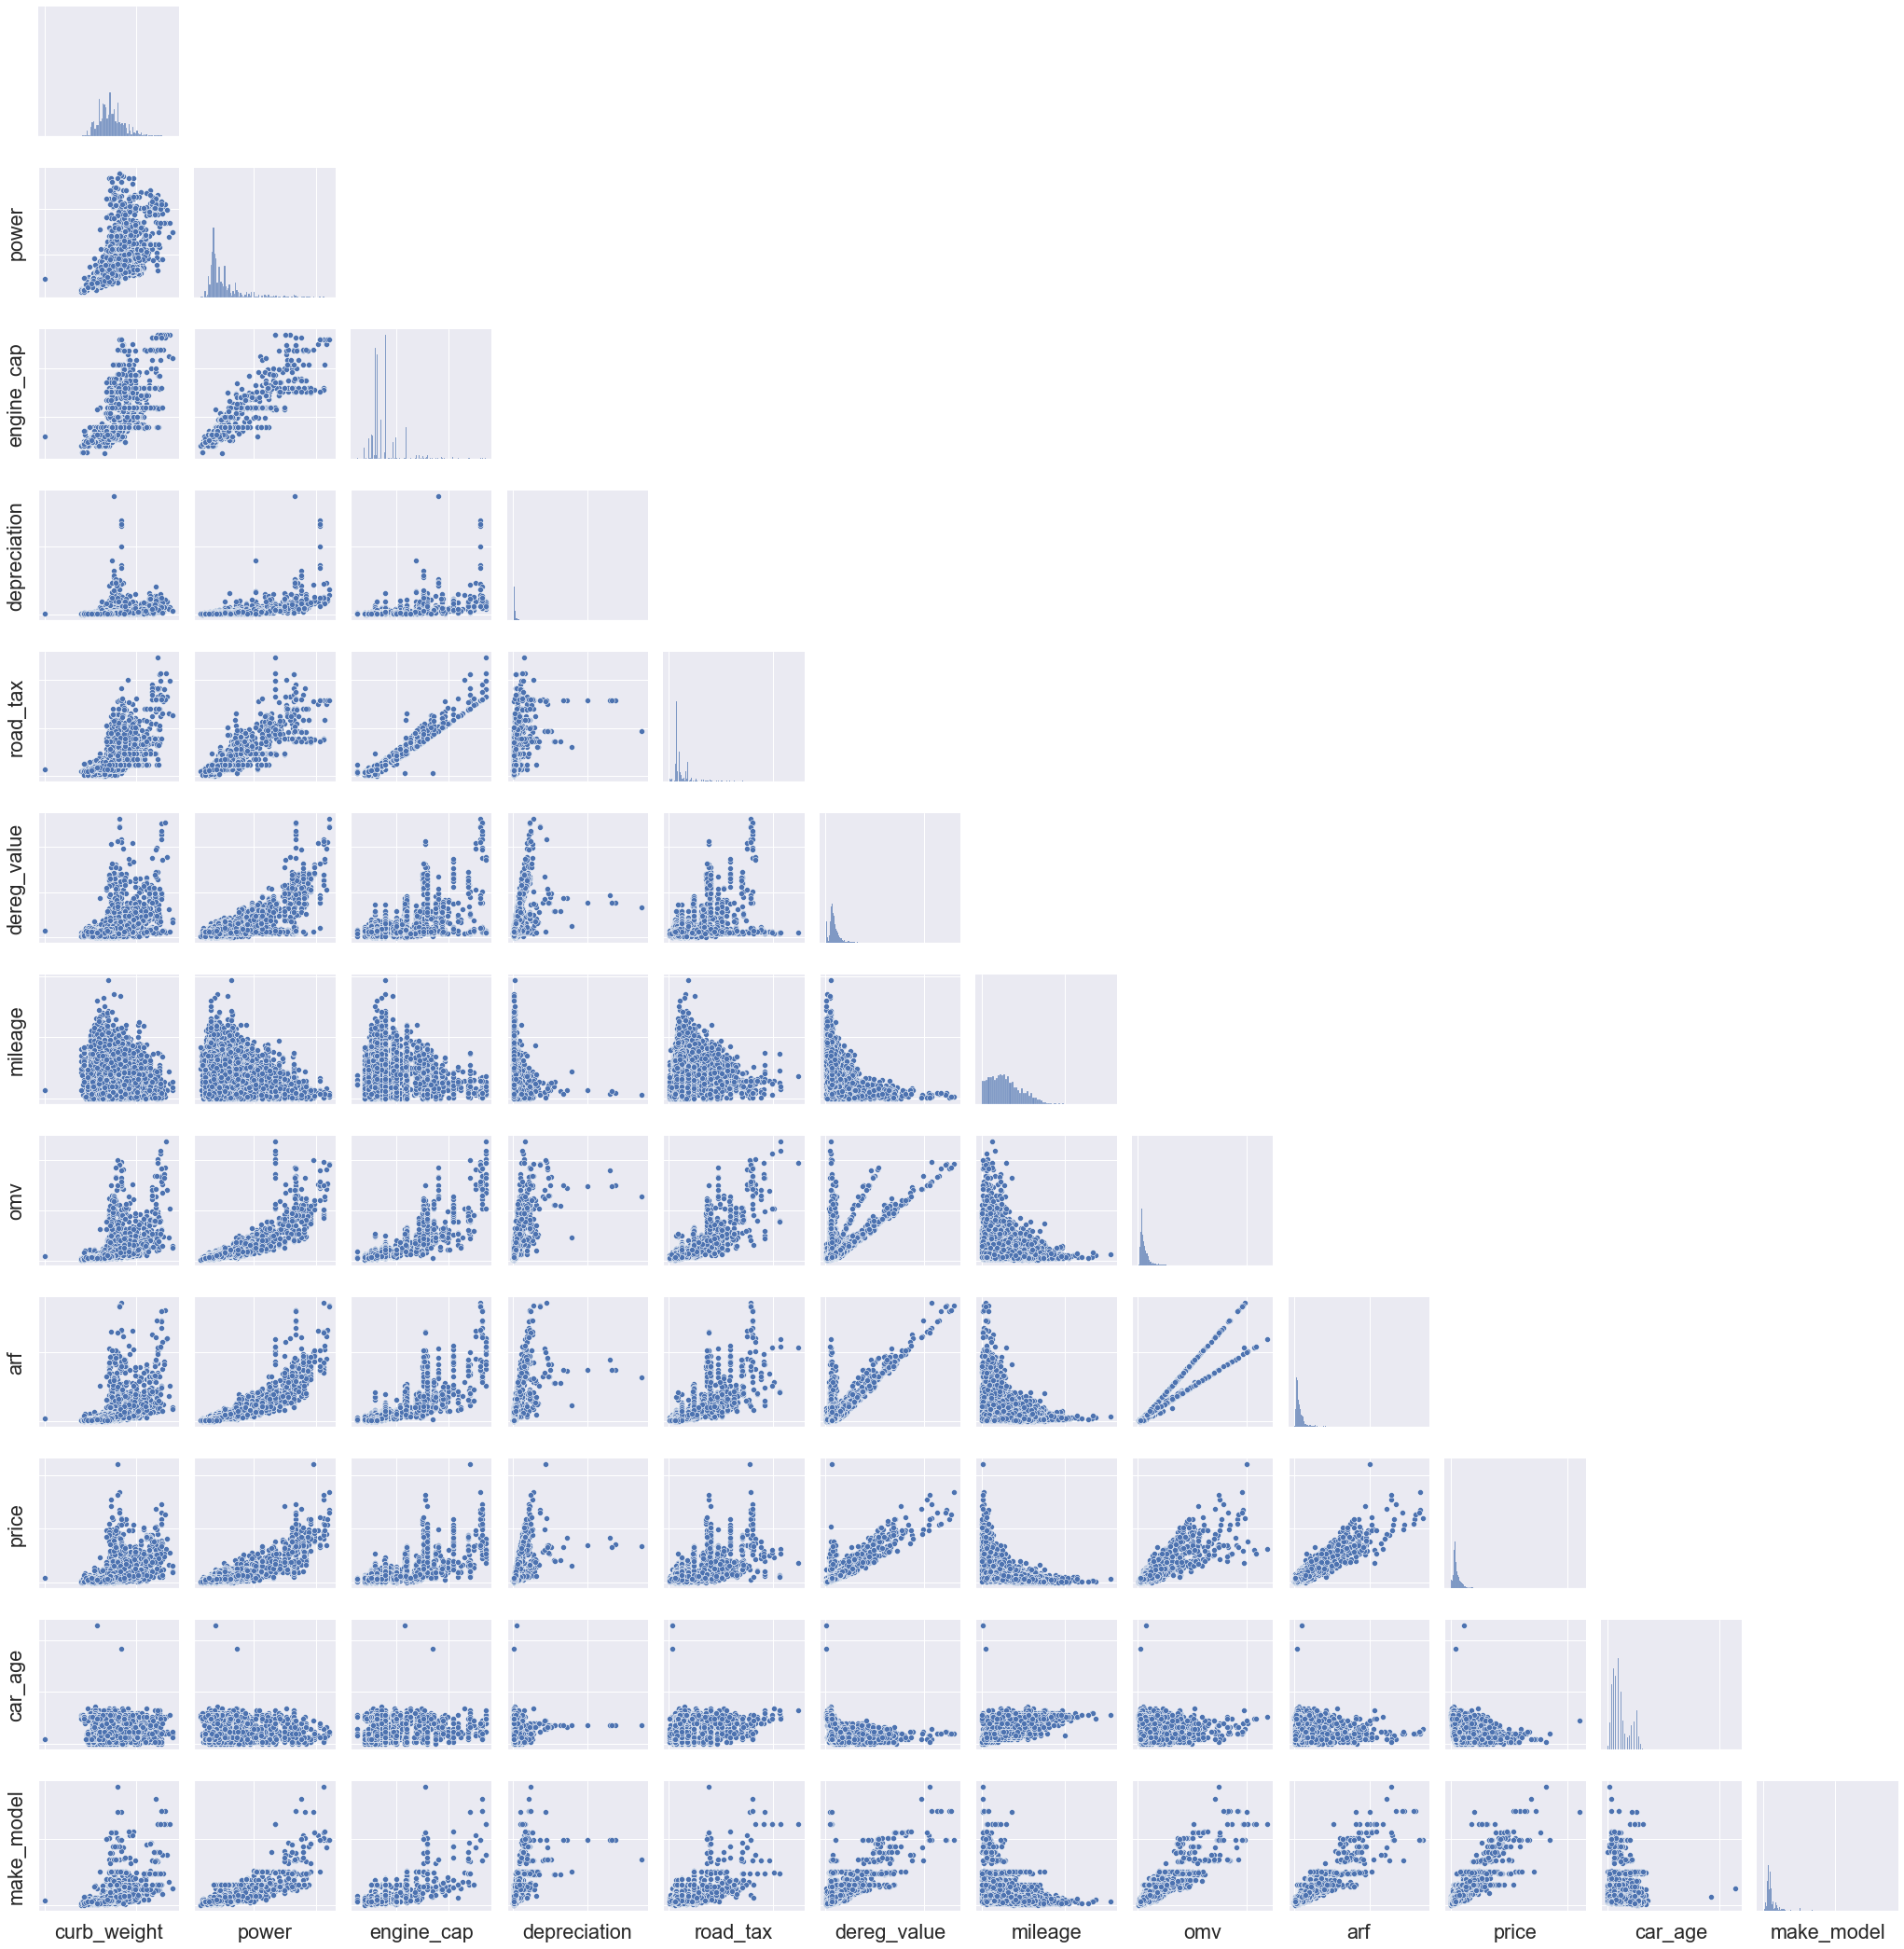

In [15]:
sns.set(font_scale=1.8)
matplotlib.rcParams['figure.figsize'] = (10, 10)
pp = sns.pairplot(df_cl_1, corner=True)

for ax in pp.axes.flat:
    if ax:
        ax.set_yticklabels([])
        ax.set_xticklabels([])

save_fig('pairplot.png')
plt.show()

<h1> Statistical Modeling </h1>

In [16]:
df = pd.read_csv(const.TRAIN_PATH)

# Removing columns that have DEFINITELY no relevance to the objective
df.drop(columns = [
                     "opc_scheme",
                     "description"], inplace=True)

Keeping only numerical columns for further analyis

In [17]:
num = df.drop(columns=["listing_id","title","make","model","category","fuel_type","features","accessories", "indicative_price"])
num.isnull().sum()
transmission = pd.get_dummies(num.transmission)
num = cln.handle_date_fields(num, is_test=True)
num.drop(columns=["registered_date"], inplace=True)

In [18]:
num.corr()['price'].sort_values(ascending=False)

price           1.000000
dereg_value     0.894838
arf             0.884832
omv             0.804580
power           0.769550
depreciation    0.631857
road_tax        0.610232
engine_cap      0.418161
manufactured    0.146126
curb_weight     0.138473
coe             0.047125
no_of_owners   -0.092642
car_age        -0.146126
mileage        -0.387148
Name: price, dtype: float64

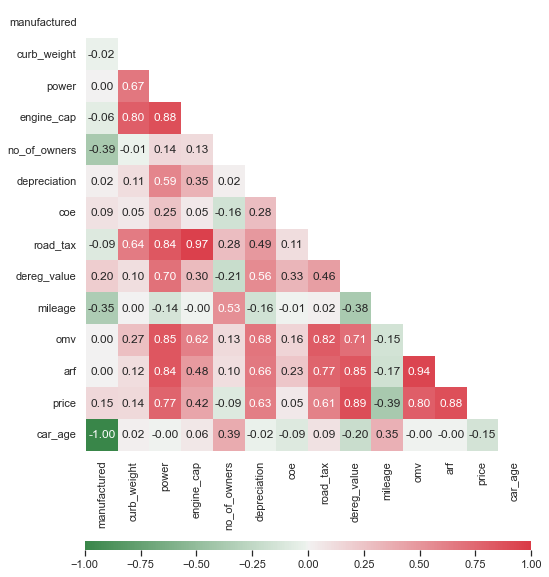

In [19]:
plot_correlation_heatmap(num)

What needs to be checked for price?

    - dereg_value

    - arf

    - omv

    - power

Which of the above have colinearities between themselves?

    - dereg_value - arf : 0.85

    - arf - omv, dereg_value, power

    - omv - arf, power

    - engine_cap - road_tax

    - arf - omv

    - power - enginer_cap,

What can be dropped?

    - manufactured

    - no_of_owners

    - arf due to to much correlation with omv

    - road tax is dropped due to correlation with engine_cap

    - manufactured is dropped

    - power will be dropped

<h2> Using features which are not heavily collinear </h2>

In [20]:
num2 = num[['curb_weight','engine_cap', 'depreciation', 'coe', 'dereg_value', 'mileage', 'omv', 'price', 'transmission', 'car_age', 'no_of_owners',]]

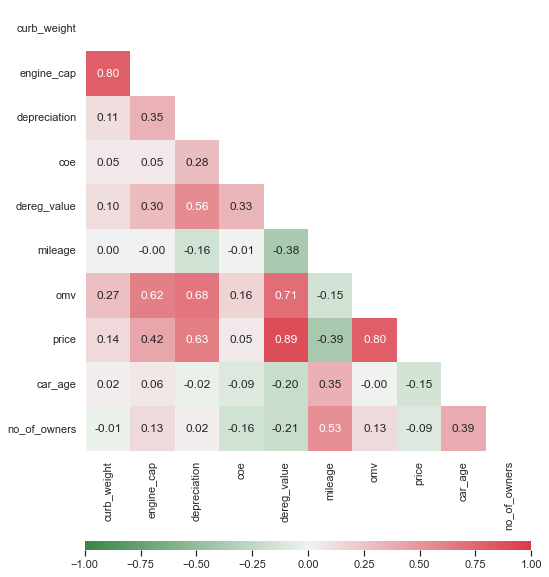

In [21]:
plot_correlation_heatmap(num2)

In [22]:
num2.corr()['price'].sort_values(ascending=False)

price           1.000000
dereg_value     0.894838
omv             0.804580
depreciation    0.631857
engine_cap      0.418161
curb_weight     0.138473
coe             0.047125
no_of_owners   -0.092642
car_age        -0.146126
mileage        -0.387148
Name: price, dtype: float64

In [23]:
num3 = num2.dropna()

<h3> OLS Regression Analysis </h3>

In [24]:
X = num3[['curb_weight','engine_cap', 'depreciation', 'coe', 'dereg_value', 'mileage', 'car_age', 'no_of_owners']]
X = sm.add_constant(X)
y = num3.price.astype('float')

l_sm = sm.OLS(y,X)
results = l_sm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                 1.058e+04
Date:                Sun, 14 Nov 2021   Prob (F-statistic):               0.00
Time:                        19:58:28   Log-Likelihood:            -1.4257e+05
No. Observations:               11823   AIC:                         2.852e+05
Df Residuals:                   11814   BIC:                         2.852e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.073e+04   1873.524     16.400      0.000    2.71e+04    3.44e+04
curb_weight    -12.7636      1.338     -9.537      0.000     -15.387     -10.140
engine_cap      30.8248      0.829     37.199      0.000      29.201      32.449
depreciation     0.8119      0.024     34.327      0.000       0.766       0.858
coe             -1.1206      0.027    -42.208      0.000      -1.173      -1.069
dereg_value      1.9188      0.012    154.759      0.000       1.895       1.943
mileage         -0.2943      0.013    -21.984      0.000      -0.321      -0.268
car_age       -563.7437    200.214     -2.816      0.005    -956.197    -171.291
no_of_owners  5540.6944    446.889     12.398      0.000    4664.718    6416.671
==============================================================================
Omnibus:                    18093.441   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         49913856.451
Skew:                           8.881   Prob(JB):                         0.00
Kurtosis:                     320.816   Cond. No.                     5.13e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h3> Checking with mileage logged and engine_cap squared </h3>

In [25]:
X = num3[['curb_weight','engine_cap', 'depreciation', 'coe', 'dereg_value', 'mileage', 'omv', 'car_age', 'no_of_owners']]

X = sm.add_constant(X)
y = num3.price.astype('float')
X.mileage = X.mileage.apply(np.log)
X.engine_cap = X.engine_cap.apply(lambda x: x**2)
l_sm = sm.OLS(y,X)
results = l_sm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                 1.295e+04
Date:                Sun, 14 Nov 2021   Prob (F-statistic):               0.00
Time:                        19:58:28   Log-Likelihood:            -1.4088e+05
No. Observations:               11823   AIC:                         2.818e+05
Df Residuals:                   11813   BIC:                         2.818e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.261e+05   3350.697     37.643      0.000     1.2e+05    1.33e+05
curb_weight      5.0648      1.171      4.325      0.000       2.769       7.360
engine_cap      -0.0005      0.000     -4.376      0.000      -0.001      -0.000
depreciation     0.2821      0.022     12.603      0.000       0.238       0.326
coe             -1.0560      0.023    -45.247      0.000      -1.102      -1.010
dereg_value      1.4430      0.013    109.409      0.000       1.417       1.469
mileage      -7440.1551    299.850    -24.813      0.000   -8027.910   -6852.400
omv              1.2082      0.018     68.421      0.000       1.174       1.243
car_age      -2466.7491    144.936    -17.020      0.000   -2750.848   -2182.650
no_of_owners  1784.9293    388.699      4.592      0.000    1023.015    2546.843
==============================================================================
Omnibus:                    16647.871   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         36418902.004
Skew:                           7.497   Prob(JB):                         0.00
Kurtosis:                     274.484   Cond. No.                     7.78e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.78e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h3> Target variable analysis </h3>

/home/sdp/anaconda3/envs/gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

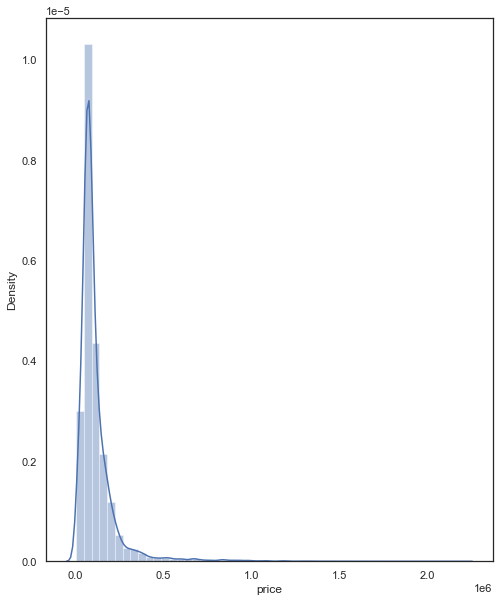

In [26]:
sns.distplot(y) 

/home/sdp/anaconda3/envs/gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

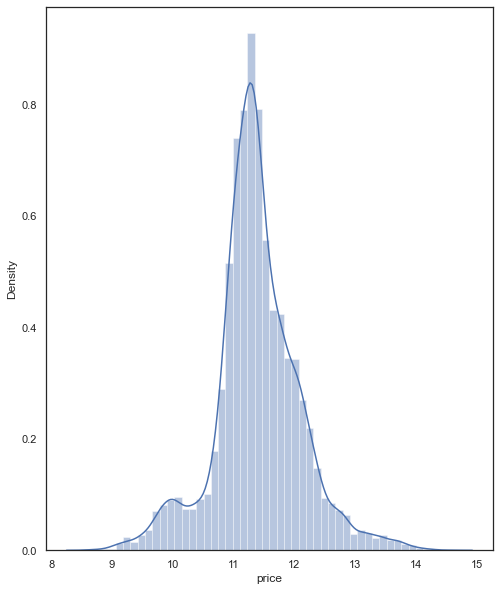

In [27]:
sns.distplot(np.log(y))

<h3> This suggests that a logarithmic value of price is better for using with correlation analysis </h3>

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [30]:
lr = RandomForestRegressor()
lr.fit(X_train, y_train)

RandomForestRegressor()

In [31]:
lr.score(X_test, y_test)

0.9466720051416951

In [32]:
y_pred = lr.predict(X_test)

In [33]:
mean_squared_error(y_pred, y_test, squared=False)

27645.285620215996